# Slab Dip and Kimberlites

Increaed magmatism is associated with slab flux. Here, we examine the slab flux at subduction zones dipping towards African and American kimberlite populations.

In [10]:
%matplotlib inline
import numpy as np
import glob, os
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from gplately import pygplates
import gplately
import cartopy.crs as ccrs
from scipy.spatial import cKDTree
import stripy

from slabdip import SlabDipper

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

In [11]:
# Call GPlately's DataServer object and download the plate model
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Set time to present day for plotting
time = 0

# Call the PlotTopologies object
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs, time=time)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [12]:
# Call GPlately's DataServer object and download the plate model
gdownload = gplately.download.DataServer("Clennett2020")
# rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# overwrite with more recent reconstructions
input_directory = "data/Global_Model_WD_Internal_Release_2019_v2_Clennett_NE_Pacific/"
rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model = pygplates.RotationModel(rotation_filenames)

coastlines = input_directory+"StaticGeometries/Coastlines/Global_coastlines_low_res.shp"
continents = input_directory+"StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp"
static_polygons = input_directory+"StaticGeometries/StaticPolygons/Clennett_2020_StaticPolygons.gpml"
COBs = input_directory+"StaticGeometries/COBLineSegments/Global_EarthByte_GeeK07_COBLineSegments_2019_v1.gpmlz"

topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)

        # Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
# coastlines, continents, COBs = gdownload.get_topology_geometries()

# Set time to present day for plotting
time = 0

# Call the PlotTopologies object
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs, time=time)

In [13]:
# grid directory
grid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = grid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"
spreadrate_filename = grid_dir+"SampleData/Rasters/spreadrate_grids/rategrid_final_mask_{:.0f}.nc"

# read in condensed kimberlite data
df_kimberlite = pd.read_excel("data/kimberlites_condensed.xlsx")
df_kimberlite = df_kimberlite[df_kimberlite['Age estimated RDM'] <= 170]
kimberlite_age = df_kimberlite['Age estimated RDM'].to_numpy()
extent_globe = [-180,180,-90,90]

kimb = gplately.Points(model, df_kimberlite['Longitude'], df_kimberlite['Latitude'])

# read in plate kinematics
df = pd.read_csv("data/subduction_data.csv")

# read in approximate trench locations
df_trench = pd.read_csv("data/trench_locations.csv")

## Plot kimberlites against Slab2 model

In [14]:
# get present day age grid
agegrid = gdownload.get_age_grid(0)

# get slab2 compiled grid
slab2_depth = gplately.Raster(filename="data/Slab2_compiled_dep.nc")


Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [15]:
def mask_data_extent(lons, lats, extent):
    mask_extent = np.zeros_like(lons, dtype=bool)
    mask_extent += lons < extent[0]
    mask_extent += lons > extent[1]
    mask_extent += lats < extent[2]
    mask_extent += lats > extent[3]
    mask_extent = np.invert(mask_extent)
    return mask_extent

In [16]:
extent_africa_kimberlites = [-30,60,-80,0]
extent_america_kimberlites = [-150,-50,30,85]

extent_south_america = [-85,-40,-80,0]
extent_north_america = [-100,-30,35,75]

# mask_llsvp_kimb = df_kimberlite['distance_to_LLSVP'] < 1e3
mask_africa_kimb  = mask_data_extent(df_kimberlite['Longitude'], df_kimberlite['Latitude'], extent_africa_kimberlites)
mask_america_kimb = mask_data_extent(df_kimberlite['Longitude'], df_kimberlite['Latitude'], extent_america_kimberlites)
mask_other_kimb = np.logical_and(~mask_africa_kimb, ~mask_america_kimb)

# separate based on plate ID
mask_america_kimb = np.logical_or(kimb.plate_id == 101, kimb.plate_id == 102)
mask_africa_kimb = np.logical_and(kimb.plate_id >= 701, kimb.plate_id <= 750)
# mask_africa_kimb += kimb.plate_id == 201
# mask_eurasia_kimb = np.logical_and(~mask_america_kimb, ~mask_pangea_kimb)

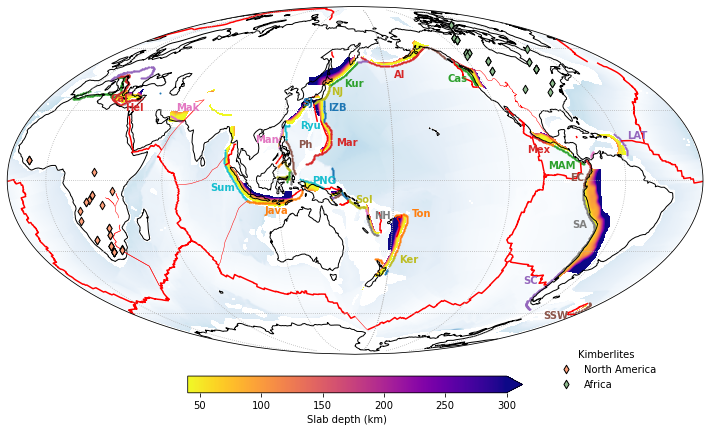

In [17]:
proj = ccrs.Mollweide(central_longitude=160)

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
ax.set_global()

im0 = ax.imshow(agegrid.data, extent=extent_globe, origin='lower',cmap='Blues',transform=ccrs.PlateCarree(), 
                alpha=0.5)
im1 = ax.imshow(-slab2_depth.data, extent=extent_globe, origin='lower', cmap='plasma_r', vmin=40, vmax=300,
                 transform=ccrs.PlateCarree())

gplot.plot_ridges_and_transforms(ax, color='r')
gplot.plot_terrane_boundaries(ax, color='r', linewidth=0.5)
gplot.plot_fracture_zones(ax, color='r', linewidth=0.5)
gplot.plot_continental_rifts(ax, color='r', linewidth=0.5)

sc1 = ax.scatter(df_kimberlite['Longitude'][mask_africa_kimb],
                 df_kimberlite['Latitude'][mask_africa_kimb],
                 color='LightSalmon', edgecolor='k', marker='d', transform=ccrs.PlateCarree(), zorder=10)

sc2 = ax.scatter(df_kimberlite['Longitude'][mask_america_kimb],
                 df_kimberlite['Latitude'][mask_america_kimb],
                 color='DarkSeaGreen', edgecolor='k', marker='d', transform=ccrs.PlateCarree(), zorder=10)



unique_segment_IDs = np.unique(df['segment_ID'])
for i, seg_ID in enumerate(unique_segment_IDs):
    mask_segment = df['segment_ID'] == seg_ID
    ax.scatter(df['lon'][mask_segment],
               df['lat'][mask_segment],
               s=1, c='C{}'.format(seg_ID), transform=ccrs.PlateCarree(), rasterized=True)
    
for i in range(df_trench.shape[0]):

    # find nearest trench segment using haversine distance
    dist = gplately.tools.haversine_distance(df['lon'], df_trench['Lon'][i], df['lat'], df_trench['Lat'][i])
    idx = dist.argmin()
    
    ax.text(df_trench['Lon'][i], df_trench['Lat'][i], df_trench['Abbreviation'][i],
            color="C{}".format(df['segment_ID'][idx]),
            fontweight='bold', transform=ccrs.PlateCarree())


ax.coastlines()
ax.gridlines(linestyle=':')
fig.legend([sc1,sc2], ['North America', 'Africa'], loc='lower right', bbox_to_anchor=(0.8,0.2),
           frameon=False, title='Kimberlites')
fig.colorbar(im1, shrink=0.4, orientation='horizontal', pad=0.05, extend='max', label='Slab depth (km)')

fig.savefig("slab2_depth.pdf", dpi=300, bbox_inches='tight')

## Slab flux relationship with kimberlites

By default, `SlabDipper` trains the neural network on the plate kinematics and rheology parameters from the previous set of notebooks to predict slab dip. These data are bundled with the `slabdip` package.

In [18]:
dipper = SlabDipper()
dipper.model = model
dipper.set_age_grid_filename(agegrid_filename)
dipper.set_spreading_rate_grid_filename(spreadrate_filename)

In [19]:
dipper.predictive_variables

Index(['angle', 'total_vel', 'vel', 'trench_vel', 'vratio', 'slab_age',
       'slab_thickness', 'spreading_rate', 'density'],
      dtype='object')

In [20]:
df = pd.read_csv("data/subduction_data.csv", index_col=0)

# remove NaN entries
df = df[np.isfinite(df['slab_dip'])]

variable_names = ['angle', 'total_vel', 'vel', 'trench_vel', 'vratio', 'slab_age', 'slab_thickness',
                  'spreading_rate', 'density']

df_X_train = df[variable_names]
df_y_train = df['slab_dip']

In [21]:
mlp = MLPRegressor(hidden_layer_sizes=(25,), solver='lbfgs', max_iter=4000, tol=0.05)
kn = KNeighborsRegressor(n_neighbors=3, )

dipper = SlabDipper(sklearn_regressor=kn, X=df_X_train, y=df_y_train)
dipper.model = model
dipper.set_age_grid_filename(agegrid_filename)
dipper.set_spreading_rate_grid_filename(spreadrate_filename)
dipper.get_score()

0.9245971470149444

In [22]:
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    
    bar_length = 20
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
def weighted_av(values, weights):
    """
    Take the weighted average of values 
    
    Some error checking to deal with empty arrays
    """
    if values.any():
        if len(values) > 1:
            return (values*weights).sum()/weights.sum()
        else:
            return values

In [26]:
radius_levels = [2.5e3, 5e3, 10e3]
reconstruction_times = np.arange(0, 171, 1)

flux_global  = np.zeros(len(reconstruction_times))
flux_africa  = np.zeros((len(reconstruction_times), len(radius_levels)))
flux_america = np.zeros((len(reconstruction_times), len(radius_levels)))

dip_global  = np.zeros(len(reconstruction_times))
dip_america = np.zeros((len(reconstruction_times), len(radius_levels)))
dip_africa  = np.zeros((len(reconstruction_times), len(radius_levels)))

for t, time in enumerate(reconstruction_times):
    df_time = dipper.tessellate_slab_dip(time)
    
    # calculate distance of arc to trench
    dip = np.clip(df_time['slab_dip'], 1, 89)
    d_trench = 125.0/np.tan(np.radians(dip))
    r_trench = d_trench/gplately.EARTH_RADIUS

    # scale by trench normal
    rlon = r_trench*np.sin(np.radians(df_time['norm']))
    rlat = r_trench*np.cos(np.radians(df_time['norm']))
    arc_lon = df_time['lon'] + np.degrees(rlon)
    arc_lat = df_time['lat'] + np.degrees(rlat)


    # calculate distance from trench and arcs to kimberlite populations
    kimb_lons, kimb_lats = kimb.reconstruct(time, return_array=True)
    kx, ky, kz = gplately.tools.lonlat2xyz(kimb_lons, kimb_lats, degrees=True)
    sx, sy, sz = gplately.tools.lonlat2xyz(df_time['lon'], df_time['lat'], degrees=True)
    ax, ay, az = gplately.tools.lonlat2xyz(arc_lon, arc_lat, degrees=True)
    
    
    tree_kimb = cKDTree(np.c_[kx,ky,kz])
    d_kimb_trench, idx_trench = tree_kimb.query(np.c_[sx,sy,sz])
    d_kimb_arc,    idx_arc    = tree_kimb.query(np.c_[ax,ay,az])
    d_kimb_trench *= gplately.EARTH_RADIUS
    d_kimb_arc    *= gplately.EARTH_RADIUS
    
    
    # mask subduction polarity in wrong direction to kimberlites
    mask_polarity = d_kimb_arc < d_kimb_trench
    
    # calculate global slab flux and slab dip
    subduction_vol_rate = df_time['vel'] * df_time['slab_thickness'] * df_time['length'] * 1e-9 # km^3
    flux_global[t] = subduction_vol_rate.sum()
    dip_global[t] = df_time['slab_dip'].mean()
    
    # calculate regional slab flux
    #mask_america_subduction = mask_data_extent(df_time['lon'], df_time['lat'], extent_north_america)
    
    for r, radius in enumerate(radius_levels):
        # mask trench segments close to kimberlite eruptions
        mask_radius = np.logical_and(mask_polarity, d_kimb_trench < radius)
        mask_radius_africa  = np.logical_and(mask_radius, mask_africa_kimb[idx_trench])
        mask_radius_america = np.logical_and(mask_radius, mask_america_kimb[idx_trench])
#         mask_radius_america = np.logical_and(mask_radius, df_time['pid_sub'] == 902)
        
        flux_africa[t,r]  = subduction_vol_rate[mask_radius_africa].sum()
        flux_america[t,r] = subduction_vol_rate[mask_radius_america].sum()

        # weighted average
        dip_africa[t,r]  = weighted_av(df_time['slab_dip'][mask_radius_africa],
                                         1.0/d_kimb_trench[mask_radius_africa])
        dip_america[t,r] = weighted_av(df_time['slab_dip'][mask_radius_america], 
                                         1.0/d_kimb_trench[mask_radius_america])

    update_progress(float(t+1)/reconstruction_times.size)

Progress: [####################] 100.0%


In [27]:
# calculate side vs down flux

flux_down_global  = np.sin(np.radians(dip_global))*flux_global
flux_down_africa  = np.sin(np.radians(dip_africa))*flux_africa
flux_down_america = np.sin(np.radians(dip_america))*flux_america

flux_side_global  = np.cos(np.radians(dip_global))*flux_global
flux_side_africa  = np.cos(np.radians(dip_africa))*flux_africa
flux_side_america = np.cos(np.radians(dip_america))*flux_america

In [28]:
from scipy.ndimage import gaussian_filter1d

def smooth_1D(array, std=3):
    return gaussian_filter1d(array, std)

## Compare global to regional associations

### Global

Text(0, 0.5, 'Slab flux (km$^3$/yr)')

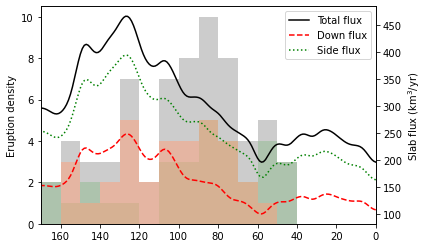

In [29]:
fig = plt.figure()
ax2 = fig.add_subplot(111, xlim=[170,0])
ax1 = ax2.twinx()
ax2.hist(kimberlite_age, bins=25, range=(0,250), color='0.8', label='All kimberlites')
ax2.hist(kimberlite_age[mask_america_kimb], bins=25, range=(0,250), color='DarkSeaGreen', label='N America', alpha=0.5)
ax2.hist(kimberlite_age[mask_africa_kimb], bins=25, range=(0,250), color='LightSalmon', label='Pangea', alpha=0.5)

ax1.plot(reconstruction_times, smooth_1D(flux_global), 'k', label='Total flux')
ax1.plot(reconstruction_times, smooth_1D(flux_down_global), 'r--', label='Down flux')
ax1.plot(reconstruction_times, smooth_1D(flux_side_global), 'g:', label='Side flux')
ax1.legend()

ax2.set_ylabel('Eruption density')
ax1.set_ylabel('Slab flux (km$^3$/yr)')

### Africa

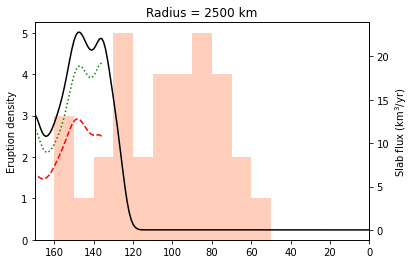

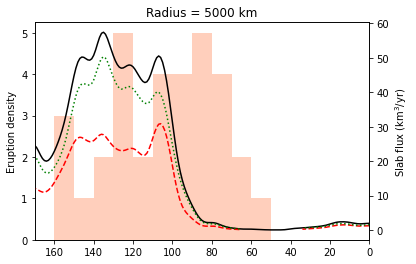

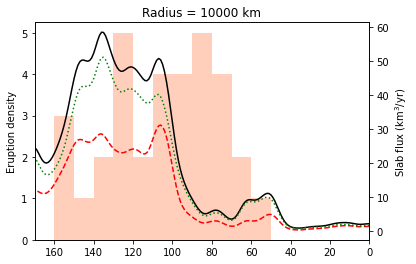

In [30]:
for r, radius_level in enumerate(radius_levels):
    fig = plt.figure()
    ax2 = fig.add_subplot(111, xlim=[170,0])
    ax1 = ax2.twinx()
    ax2.hist(kimberlite_age[mask_africa_kimb], bins=25, range=(0,250), color='LightSalmon',
             label='Africa', alpha=0.5)

    ax1.plot(reconstruction_times, smooth_1D(flux_africa[:,r]), 'k')
    ax1.plot(reconstruction_times, smooth_1D(flux_down_africa[:,r]), 'r--')
    ax1.plot(reconstruction_times, smooth_1D(flux_side_africa[:,r]), 'g:')
    ax2.set_title('Radius = {:.0f} km'.format(radius_level))
    ax2.set_ylabel('Eruption density')
    ax1.set_ylabel('Slab flux (km$^3$/yr)')
    # fig.savefig("images/Africa_radius_{}.pdf".format(radius_levels[r]), bbox_inches='tight')

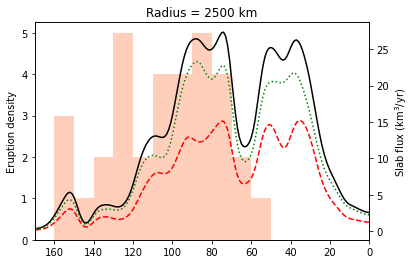

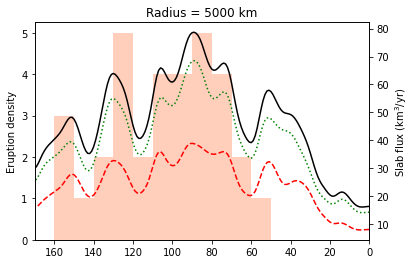

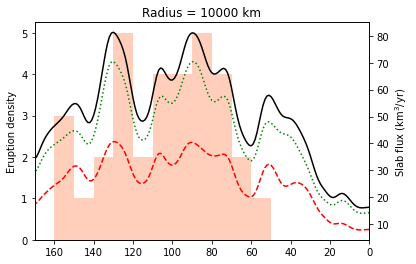

In [31]:
# America flux in Africa

for r, radius_level in enumerate(radius_levels):
    fig = plt.figure()
    ax2 = fig.add_subplot(111, xlim=[170,0])
    ax1 = ax2.twinx()
    ax2.hist(kimberlite_age[mask_africa_kimb], bins=25, range=(0,250), color='LightSalmon',
             label='Africa', alpha=0.5)

    ax1.plot(reconstruction_times, smooth_1D(flux_america[:,r]), 'k')
    ax1.plot(reconstruction_times, smooth_1D(flux_down_america[:,r]), 'r--')
    ax1.plot(reconstruction_times, smooth_1D(flux_side_america[:,r]), 'g:')
    ax2.set_title('Radius = {:.0f} km'.format(radius_level))
    ax2.set_ylabel('Eruption density')
    ax1.set_ylabel('Slab flux (km$^3$/yr)')
    # fig.savefig("images/Africa_radius_{}.pdf".format(radius_levels[r]), bbox_inches='tight')

### North America

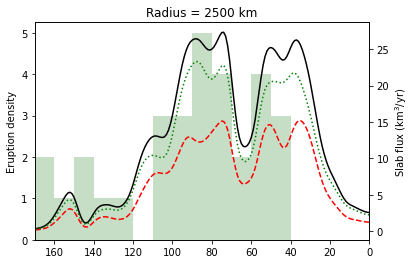

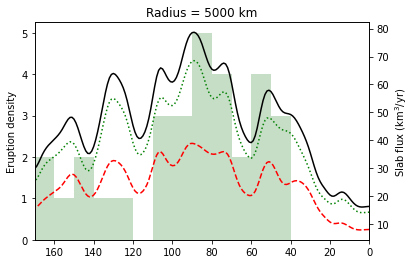

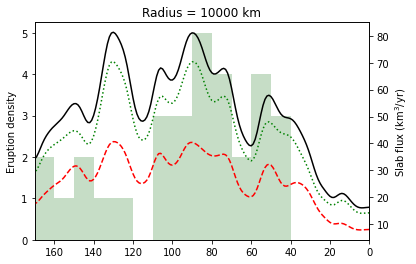

In [32]:
for r, radius_level in enumerate(radius_levels):
    fig = plt.figure()
    ax2 = fig.add_subplot(111, xlim=[170,0])
    ax1 = ax2.twinx()
    
    ax2.hist(kimberlite_age[mask_america_kimb], bins=25, range=(0,250), color='DarkSeaGreen',
             label='N America', alpha=0.5)

    ax1.plot(reconstruction_times, smooth_1D(flux_america[:,r]), 'k')
    ax1.plot(reconstruction_times, smooth_1D(flux_down_america[:,r]), 'r--')
    ax1.plot(reconstruction_times, smooth_1D(flux_side_america[:,r]), 'g:')
    ax2.set_title('Radius = {:.0f} km'.format(radius_levels[r]))

    ax2.set_ylabel('Eruption density')
    ax1.set_ylabel('Slab flux (km$^3$/yr)')
    # fig.savefig("images/NorthAmerica_radius_{}.pdf".format(radius_levels[r]), bbox_inches='tight')

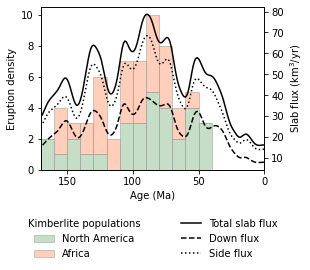

In [33]:
fig = plt.figure(figsize=(4,3))
ax2 = fig.add_subplot(111, xlim=[170,0])
ax1 = ax2.twinx()

H0, xedges = np.histogram(kimberlite_age, bins=25, range=(0,250))
H1, xedges = np.histogram(kimberlite_age[mask_america_kimb], bins=25, range=(0,250))
H2, xedges = np.histogram(kimberlite_age[mask_africa_kimb], bins=25, range=(0,250))
xedges = 0.5*(xedges[:-1] + xedges[1:])

b1 = ax2.bar(xedges, height=H1, width=10, color='DarkSeaGreen', label='North America', alpha=0.5, edgecolor='0.6')
b2 = ax2.bar(xedges, height=H2, width=10, bottom=H1,color='LightSalmon', label='Africa', alpha=0.5,edgecolor='0.6')
# ax2.hist(kimberlite_age, bins=25, range=(0,250), color='0.8', label='All', alpha=0.5)

ax1.plot(reconstruction_times, smooth_1D(flux_america[:,1]), 'k', label='Total slab flux')
ax1.plot(reconstruction_times, smooth_1D(flux_down_america[:,1]), 'k--', label='Down flux')
ax1.plot(reconstruction_times, smooth_1D(flux_side_america[:,1]), 'k:', label='Side flux')
ax1.legend(frameon=False, loc='lower right', bbox_to_anchor=(1.1,-0.6))

ax2.legend(loc='lower left', frameon=False, title='Kimberlite populations', bbox_to_anchor=(-0.1,-0.6))

ax2.set_ylabel('Eruption density')
ax1.set_ylabel('Slab flux (km$^3$/yr)')
ax2.set_xlabel('Age (Ma)')
ax2.set_xticks(range(0,200,50))

# fig.savefig("kimberlite_slab_flux_combined.pdf", dpi=300, bbox_inches='tight')

In [34]:
df_vel_africa = pd.read_csv("data/kinematics_africa.csv")
df_vel_america = pd.read_csv("data/kinematics_north_america.csv")
df_vel_farallon = pd.read_csv("data/kinematics_farallon_NAmerica.csv")

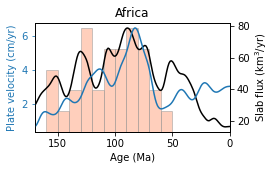

In [35]:
fig = plt.figure(figsize=(3.5,2))
ax2 = fig.add_subplot(111, xlim=[170,0], title='Africa')
ax0 = ax2.twinx()
ax1 = ax2.twinx()

# ax2.hist(kimberlite_age, bins=25, range=(0,250), color='0.8', label='All kimberlites')
# ax2.hist(kimberlite_age[mask_america_kimb], bins=25, range=(0,250), color='DarkSeaGreen', label='N America', alpha=0.5)
ax2.hist(kimberlite_age[mask_africa_kimb], bins=25, range=(0,250), color='LightSalmon', label='Africa', alpha=0.5,
         edgecolor='0.6')
ax2.set_yticks([])

ax0.plot(reconstruction_times, smooth_1D(flux_america[:,1]), 'k', label='Total slab flux')

# ax1.plot(reconstruction_times, smooth_1D(flux_america[:,1]), 'k')
ax1.plot(df_vel_africa['Time (Ma)'], smooth_1D(df_vel_africa['V mag (cm/yr)']),
         c='C0', label='Total slab flux', )
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()
ax1.tick_params(axis='y', colors='C0')

ax1.set_ylabel('Plate velocity (cm/yr)', color='C0')
ax0.set_ylabel('Slab flux (km$^3$/yr)')
ax2.set_xlabel('Age (Ma)')

fig.savefig("kimberlite_slab_flux_Africa.pdf", bbox_inches='tight', dpi=300)

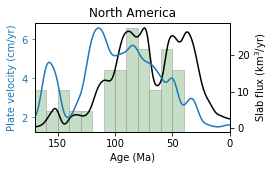

In [36]:
fig = plt.figure(figsize=(3.5,2))
ax2 = fig.add_subplot(111, xlim=[170,0], title='North America')
ax0 = ax2.twinx()
ax1 = ax2.twinx()

# ax2.hist(kimberlite_age, bins=25, range=(0,250), color='0.8', label='All kimberlites')
ax2.hist(kimberlite_age[mask_america_kimb], bins=25, range=(0,250), color='DarkSeaGreen', label='N America',
         edgecolor='0.6', alpha=0.5)
# ax2.hist(kimberlite_age[mask_africa_kimb], bins=25, range=(0,250), color='LightSalmon', label='Africa', alpha=0.5,
#          edgecolor='0.6')
ax2.set_yticks([])

ax0.plot(reconstruction_times, smooth_1D(flux_america[:,0]), 'k', label='Total slab flux')

# ax1.plot(reconstruction_times, smooth_1D(flux_america[:,1]), 'k')
ax1.plot(df_vel_america['Time (Ma)'], smooth_1D(df_vel_america['V mag (cm/yr)']),
         c='C0', label='Total slab flux', )
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()
ax1.tick_params(axis='y', colors='C0')

ax1.set_ylabel('Plate velocity (cm/yr)', color='C0')
ax0.set_ylabel('Slab flux (km$^3$/yr)')
ax2.set_xlabel('Age (Ma)')

fig.savefig("kimberlite_slab_flux_NAmerica.pdf", bbox_inches='tight', dpi=300)

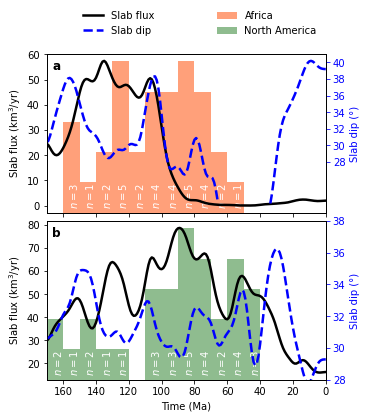

In [37]:

fig, (ax0,ax3) = plt.subplots(2,1, figsize=(5,6), sharex=True, gridspec_kw={'height_ratios': [0.5, 0.5]})

ax0.set_xlim(170,0)
ax1 = ax0.twinx()
ax2 = ax1.twinx()


nbins0, bins0, H0 = ax0.hist(kimberlite_age[mask_africa_kimb],  bins=25, range=(0,250),
                             color='LightSalmon', label='Africa')
for t, b in zip(bins0, nbins0):
    if b > 0:
        label = r'$n={:.0f}$'.format(b)
        ax0.text(t+7, 0.2, label, color='w', fontweight='bold', rotation=90)
ax0.set_yticks([])


# ax1.legend(frameon=False, loc='upper left', title="Kimberlite region", bbox_to_anchor=(0.05,1))
r = 1
ax1.plot(reconstruction_times, smooth_1D(flux_africa[:,r]), c='k', label='Slab flux', linewidth=2.5)
# ln1, = ax1.plot(reconstruction_times, smooth_1D(flux_down_africa[:,r]), c='k', linestyle='--', label='Slab down flux', linewidth=2.5)
# ln2, = ax1.plot(reconstruction_times, smooth_1D(flux_side_africa[:,r]), c='k', linestyle=':',  label='Slab side flux', linewidth=2.5)
ax1.yaxis.set_label_position("left")
ax1.set_ylabel('Slab flux (km$^3$/yr)')

# ln1, = ax2.plot(df_vel_africa['Time (Ma)'], smooth_1D(df_vel_africa['Ang V (°/Ma)']), c='b', label='Total slab flux', linewidth=2.5)
# ax2.legend(loc='upper right', frameon=False, )
ax2.plot(reconstruction_times, smooth_1D(dip_africa[:,r]), c='b', linewidth=2.5, linestyle='--')
ax2.set_ylabel('Slab dip (°)', color='b')
ax2.tick_params('y', colors='b')
ax2.set_yticks(np.arange(28,42,2))

ax3.set_xlabel('Time (Ma)')
ax3.set_xlim(170,0)
ax4 = ax3.twinx()
ax5 = ax4.twinx()
nbins3, bins3, H3 = ax3.hist(kimberlite_age[mask_america_kimb],  bins=25, range=(0,250), color='DarkSeaGreen')
for t, b in zip(bins3, nbins3):
    if b > 0:
        ax3.text(t+7, 0.2, r'$n={:.0f}$'.format(b), color='w', fontweight='bold', rotation=90)
ax3.set_yticks([])

r = 1
l4a, = ax4.plot(reconstruction_times, smooth_1D(flux_america[:,r]), c='k', linewidth=2.5,)
# l4b, = ax4.plot(reconstruction_times, smooth_1D(flux_down_america[:,r]), c='k', linestyle='--', linewidth=2.5,)
# l4c, = ax4.plot(reconstruction_times, smooth_1D(flux_side_america[:,r]), c='k', linestyle=':', linewidth=2.5)
ax4.yaxis.set_label_position("left")
ax4.set_ylabel('Slab flux (km$^3$/yr)')
# ax3.plot(reconstruction_times, smooth_1D(d_llsvp[:,mask_america_kimb].mean(axis=1)), c='C0', linewidth=2.5, label='North America')
# ax3.plot(reconstruction_times, smooth_1D(d_llsvp[:,mask_other_kimb].mean(axis=1)), c='0.5', linewidth=2.5, label='Other')
# ax3.set_yticks([0, 1000, 2000, 3000, 4000, 5000])
# ax3.legend(loc='upper left', frameon=False, title='Kimberlite region', bbox_to_anchor=(0.05,1))


# ax4.plot(reconstruction_times, smooth_1D(flux_side_america[:,0]), c='g')
# ax4.plot(reconstruction_times, smooth_1D(flux_down_america[:,0]), c='r')

l5a, = ax5.plot(reconstruction_times, smooth_1D(dip_america[:,r]), c='b', linewidth=2.5, linestyle='--')
# ax5.plot(reconstruction_times, smooth_1D(dip_america[:,r]), c='r', linewidth=2.5, linestyle='--')
ax5.set_ylabel('Slab dip (°)', color='b')
ax5.tick_params('y', colors='b')
ax5.set_yticks(np.arange(28,40,2))
ax5.set_ylim(28,38)

leg2 = fig.legend([H0, H3], ['Africa', 'North America'],
                  frameon=False, loc='upper right', bbox_to_anchor=(0.9,1))
leg1 = fig.legend([l4a, l5a], ['Slab flux', 'Slab dip'],
                  frameon=False, loc='upper left', bbox_to_anchor=(0.2,1),)

fig.subplots_adjust(hspace=0.05)
ax3.text(0.02, 0.9, 'b', fontweight='bold', fontsize=12, transform=ax3.transAxes)
ax1.text(0.02, 0.9, 'a', fontweight='bold', fontsize=12, transform=ax1.transAxes)

fig.savefig('kimberlite_slab_flux.pdf', bbox_inches='tight', dpi=300)